# make_ini:
## Make initial conditions, using salt and temp from BRAN
### Version id:
### v1. Based on script from Ole Richter
### v2. Updates on version edited by D.Gwyther
### v3. Corrected from TEOS-10 to model EOS.
### v4. Switched to BRAN forcing.

In [1]:
run = 'seqld_1km'
version_no = 'BRAN_v1'
which_ini_time = '2012_01' # for BRAN, format of YYYY_MM

import xarray as xr
from netCDF4 import Dataset
import numpy as np 
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob

import socket
comp_name = socket.gethostname()
if comp_name=='SEES-3PV4VV3':
    print('running locally')
else:
    os.chdir('/g/data/jk72/deg581/se-qld-setup/notebooks')


proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)

from ext.tools.calc_z import calc_z as calc_z_old
try: 
    from functions import GridStiffness
except:
    print('couldn''t load')

# from functions import GridStiffness


# set user parameter and call main routine
grd_file = os.path.join(data_dir,'proc','seqld_1km_v1.5_grd.nc')
out_file = os.path.join(data_dir,'proc',run+'_'+version_no+'_ini.nc')

# define inpaint_nans
from scipy.signal import convolve2d
def inpaint_nans(inField):
    im = inField.copy()
    import scipy
    ipn_kernel = np.array([[1,1,1],[1,0,1],[1,1,1]]) # kernel for inpaint_nans
    nans = np.isnan(im)
    while np.sum(nans)>0:
        im[nans] = 0
        vNeighbors = convolve2d((nans==False),ipn_kernel,mode='same',boundary='symm')
        im2 = convolve2d(im,ipn_kernel,mode='same',boundary='symm')
        im2[vNeighbors>0] = im2[vNeighbors>0]/vNeighbors[vNeighbors>0]
        im2[vNeighbors==0] = np.nan
        im2[(nans==False)] = im[(nans==False)]
        im = im2
        nans = np.isnan(im)
    return im


# Path to ECCO2 files for temperature and salinity 1th January 2007
import socket
comp_name = socket.gethostname()
    
if comp_name=='SEES-3PV4VV3':
    frc_path = os.path.join('../data/raw/BRAN2020/')
    frc_sub_paths = ['./']
else:
    frc_path = os.path.join('/g/data/gb6/BRAN/BRAN2020/')
    frc_sub_paths = ['./daily/']



# Grid parameters; check grid_file and *.in file to make sure these are correct
N=31
Vtransform=2
Vstretching=4
theta_s=4
theta_b=1
Tcline=50
hc=Tcline # if Vtransform==2, hc=Tcline

# upper and lower bounds for temp and salinity
tempUp = 10
tempLow = -3

saltUp = 34.8
saltLow = 33.2


running locally



In [2]:
grid = xr.open_dataset(grd_file)


grd_lon_ax = np.array((grid.lon_rho.min().values*0.9, grid.lon_rho.max().values*1.1))
grd_lat_ax = np.array((grid.lat_rho.min().values*1.1, grid.lat_rho.max().values*0.9))

In [3]:
def interp_bran2roms (A, lon_bran, lat_bran, depth_bran, lon_roms_3d, lat_roms_3d, z_roms_3d, mask_rho, mask_zice):

    # Calculate N based on size of ROMS grid
    N = np.size(lon_roms_3d, 0)

    eta_roms,xi_roms=np.mgrid[0:np.size(lon_roms_3d,1),0:np.size(lon_roms_3d,2)]

    # Unmask A and fill with NaNs
    A_unmask = A.data
    A_unmask[A.mask]=np.NaN

    # Build a function for linear interpolation of A; set flag to fill
    # out-of-bounds values with NaN
    interp_function = RegularGridInterpolator((lon_bran, lat_bran, depth_bran), A_unmask, method='linear', bounds_error=False, fill_value=np.NaN)
    B = np.zeros(np.shape(lon_roms_3d))

    # Interpolate each z-level individually - 3D vectorisation uses too
    # much memory!
    for k in range(N):
        print('...vertical level ', str(k+1), ' of ', str(N))
        # Pass positive values for ROMS depth
        B[k] = interp_function((lon_roms_3d[k,:,:], lat_roms_3d[k,:,:], -z_roms_3d[k,:,:]))
        #Fill NaNs with constant value
        # index = isnan(tmp)
        # tmp[index] = fill
        # #Fill land mask with constant value
        # tmp[mask_rho==0] = fill
        # Save this depth level
        #B[k,:,:] = tmp
    print('Extrapolating under ice shelves')   
    
    for k in range(N):
            
        print('processing depth level: ',k)
        data = B[k]

        valid_mask = ~np.isnan(data)
        coords = np.array(np.nonzero(valid_mask)).T
        values = data[valid_mask]

        #it = NearestNDInterpolator(coords,values)
        it = LinearNDInterpolator(coords,values)

        filled = it(list(np.ndindex(data.shape))).reshape(data.shape)

        # Fill in known values on high res grid
        B[k] = filled
    
    print('inpaint any remaining nans')
    for k in range(N):
        print('inpainting depth level: ',k)
        data = B[k]
        inpainted = inpaint_nans(data)
        B[k] = inpainted    
    
    return B

    

In [4]:
# Load BRAN data

#temp 
file_list=[]
file_name_format = 'ocean_temp_'+which_ini_time+'.nc'
for subfolder in frc_sub_paths:
    file_list = file_list+glob.glob(frc_path+subfolder+file_name_format)
theta_full = xr.open_mfdataset(file_list,decode_times=True)

# #salt
file_list=[]
file_name_format = 'ocean_salt_'+which_ini_time+'.nc'
for subfolder in frc_sub_paths:
    file_list = file_list+glob.glob(frc_path+subfolder+file_name_format)
salt_full = xr.open_mfdataset(file_list,decode_times=True)


In [5]:
convertFromTEOS=False
if convertFromTEOS:
    # convert conservative temperature to potential temperature; and absolute salinity to prac salinity.
    import gsw 
    # salt_abs = salt_full.copy()
    theta_cons = theta_full.copy()
    theta_pot = gsw.pt_from_CT(salt_abs.salt,theta_cons.temp-273.15)
    # salt_pss = gsw.SP_from_SA(salt_abs.salt, theta_cons.st_ocean, theta_cons.xt_ocean, theta_cons.yt_ocean)

    # add new variables to original dataset
    # salt_full = salt_full.rename(name_dict={'salt':'salt_abs'})
    theta_full = theta_full.rename(name_dict={'temp':'temp_cons'})

    # salt_full['salt']=salt_pss
    # salt_full.salt.attrs['long_name'] = 'Potential Temperature' 
    # salt_full.salt.attrs['units'] = 'degrees C' 
    # salt_full.salt.attrs['standard_name'] = 'sea_water_potential_temperature' 

    theta_full['temp']=theta_pot
    theta_full.temp.attrs['long_name'] = 'Potential Temperature' 
    theta_full.temp.attrs['units'] = 'degrees C' 
    theta_full.temp.attrs['standard_name'] = 'sea_water_potential_temperature' 


    




In [6]:
# # add new variables to original dataset

# # salt_full = salt_full.rename(name_dict={'salt':'salt_abs'})
# theta_full = theta_full.rename(name_dict={'temp':'temp_cons'})

# # salt_full['salt']=salt_pss
# # salt_full.salt.attrs['long_name'] = 'Potential Temperature' 
# # salt_full.salt.attrs['units'] = 'degrees C' 
# # salt_full.salt.attrs['standard_name'] = 'sea_water_potential_temperature' 

# theta_full['temp']=theta_pot
# theta_full.temp.attrs['long_name'] = 'Potential Temperature' 
# theta_full.temp.attrs['units'] = 'degrees C' 
# theta_full.temp.attrs['standard_name'] = 'sea_water_potential_temperature' 



In [7]:
# theta_ds = theta_full.assign_coords({'xt_ocean': (theta_full['xt_ocean'] + 360) % 360}).sortby('xt_ocean') # re-arrange the x-coordinate
# print(theta_ds.temp.shape)
# theta_raw = theta_ds.temp.sel(yt_ocean=slice(*grd_lat_ax),xt_ocean=slice(*grd_lon_ax)).transpose().isel(time=0)
# print(theta_raw.shape)
# print(theta_raw.xt_ocean.values)

In [6]:
print('making ini file for grid file: ' + grd_file)

# call function that generates the out file
grid_file=grd_file
output_file=out_file
tempbounds=(tempLow,tempUp)
saltbounds=(saltLow,saltUp)


# Read BRAN data and grid
print('Subsetting BRAN data')
theta_ds = theta_full.assign_coords({'xt_ocean': (theta_full['xt_ocean'] + 360) % 360}).sortby('xt_ocean') # re-arrange the x-coordinate
# theta_raw = np.transpose(theta_ds.THETA.values[0,:,0:nbdry_ecco,:])
theta_raw = theta_ds.temp.sel(yt_ocean=slice(*grd_lat_ax),xt_ocean=slice(*grd_lon_ax)).transpose().isel(Time=0)
lon_bran_raw = theta_raw.xt_ocean.values
lat_bran = theta_raw.yt_ocean.values
depth_bran_raw = theta_raw.st_ocean.values

salt_ds = salt_full.assign_coords({'xt_ocean': (salt_full['xt_ocean'] + 360) % 360}).sortby('xt_ocean') # re-arrange the x-coordinate
# salt_raw = np.transpose(salt_ds.SALT.values[0,:,0:nbdry_ecco,:])
salt_raw = salt_ds.salt.sel(yt_ocean=slice(*grd_lat_ax),xt_ocean=slice(*grd_lon_ax)).transpose().isel(Time=0)
# The ECCO2 longitude axis doesn't wrap around; there is a gap between
# almost-180W and almost-180E, and the ROMS grid has points in this gap.
# So copy the last longitude value (mod 360) to the beginning, and the
# first longitude value (mod 360) to the end.
# lon_ecco = np.zeros(np.size(lon_ecco_raw)+2)
# lon_ecco[0] = lon_ecco_raw[-1]-360
# lon_ecco[1:-1] = lon_ecco_raw
# lon_ecco[-1] = lon_ecco_raw[0]+360
lon_bran = lon_bran_raw

# The shallowest ECCO2 depth value is 5 m, but ROMS needs 0 m. So add the
# index depth = 0 m to the beginning. Later we will just copy the 5 m values
# for theta and salt into this index. Similarly, add the index depth = 6000 m
# to the end.
depth_bran = np.zeros(np.size(depth_bran_raw)+2)
depth_bran[0] = 0.0
depth_bran[1:-1] = depth_bran_raw
depth_bran[-1] = 6000.0

# Copy the theta and salt values to the new longitude and depth indices,
# making sure to preserve the mask.
theta = np.ma.array(np.zeros((np.size(lon_bran), np.size(lat_bran), np.size(depth_bran))))
theta[:,:,1:-1] = np.ma.copy(theta_raw) # modification to not overwrite the first/last lon values (so change 1:-1 to :)
# theta[0,:,1:-1] = np.ma.copy(theta_raw[-1,:,:])
# theta[-1,:,1:-1] = np.ma.copy(theta_raw[0,:,:])
theta[:,:,0] = np.ma.copy(theta[:,:,1])
theta[:,:,-1] = np.ma.copy(theta[:,:,-2])
salt = np.ma.array(np.zeros((np.size(lon_bran), np.size(lat_bran), np.size(depth_bran))))
salt[:,:,1:-1] = np.ma.copy(salt_raw)  # modification to not overwrite the first/last lon values (so change 1:-1 to :)
# salt[0,:,1:-1] = np.ma.copy(salt_raw[-1,:,:])
# salt[-1,:,1:-1] = np.ma.copy(salt_raw[0,:,:])
salt[:,:,0] = np.ma.copy(salt[:,:,1])
salt[:,:,-1] = np.ma.copy(salt[:,:,-2])


making ini file for grid file: /home/woden/Documents/se-qld-setup/data/proc/seqld_1km_v1.5_grd.nc
Subsetting BRAN data


In [7]:

# Read ROMS grid
print('Reading ROMS grid')
grid_fid = Dataset(grid_file, 'r')
lon_roms = grid_fid.variables['lon_rho'][:,:]
#ecco goes from 0 to 360 roms from -180 to 180
for i in range(len(lon_roms)):
    for j in range(len(lon_roms[i])):
        if lon_roms[i,j] < 0:
            lon_roms[i,j] = lon_roms[i,j] + 360
lat_roms = grid_fid.variables['lat_rho'][:,:]
h = grid_fid.variables['h'][:,:]
# zice = grid_fid.variables['zice'][:,:]
mask_rho = grid_fid.variables['mask_rho'][:,:]
#mask_zice = grid_fid.variables['mask_zice'][:,:]
grid_fid.close()
# mask_zice = np.where(zice < 0.0,1,0)*mask_rho
num_lon = np.size(lon_roms, 1)
num_lat = np.size(lon_roms, 0)
# Mask h and zice with zeros
h = h*mask_rho
# zice = zice*mask_zice

# Get a 3D array of ROMS z-coordinates, as well as 1D arrays of s-coordinates
# and stretching curves
z_roms_3d, sc_r, Cs_r = calc_z_old(h, np.full_like(h,0.0), theta_s, theta_b, hc, N)
# Copy the latitude and longitude values into 3D arrays of the same shape
lon_roms_3d = np.tile(lon_roms, (N,1,1))
lat_roms_3d = np.tile(lat_roms, (N,1,1))


Reading ROMS grid


In [19]:
temp = interp_bran2roms(theta, lon_bran, lat_bran, depth_bran, lon_roms_3d, lat_roms_3d, z_roms_3d, mask_rho, np.full_like(h,0))


...vertical level  1  of  31
...vertical level  2  of  31
...vertical level  3  of  31
...vertical level  4  of  31
...vertical level  5  of  31
...vertical level  6  of  31
...vertical level  7  of  31
...vertical level  8  of  31
...vertical level  9  of  31
...vertical level  10  of  31
...vertical level  11  of  31
...vertical level  12  of  31
...vertical level  13  of  31
...vertical level  14  of  31
...vertical level  15  of  31
...vertical level  16  of  31
...vertical level  17  of  31
...vertical level  18  of  31
...vertical level  19  of  31
...vertical level  20  of  31
...vertical level  21  of  31
...vertical level  22  of  31
...vertical level  23  of  31
...vertical level  24  of  31
...vertical level  25  of  31
...vertical level  26  of  31
...vertical level  27  of  31
...vertical level  28  of  31
...vertical level  29  of  31
...vertical level  30  of  31
...vertical level  31  of  31
Extrapolating under ice shelves
processing depth level:  0
processing depth lev

In [20]:

def smooth_initialfield(N,field):
    import scipy as sp
    import scipy.ndimage
    
    field_new = np.empty(field.shape)

    for k in range(N):
        print('processing depth level: ',k)
        data = field[k]
        
        
        sigma_y = 2.0
        sigma_x = 2.0
        sigma = [sigma_y, sigma_x]

        data_smoothed = sp.ndimage.gaussian_filter(data, sigma, mode='nearest')
        
        
        field_new[k] = data_smoothed
    return field_new
        
temp_backup = temp.copy()
temp = smooth_initialfield(N,temp)

processing depth level:  0
processing depth level:  1
processing depth level:  2
processing depth level:  3
processing depth level:  4
processing depth level:  5
processing depth level:  6
processing depth level:  7
processing depth level:  8
processing depth level:  9
processing depth level:  10
processing depth level:  11
processing depth level:  12
processing depth level:  13
processing depth level:  14
processing depth level:  15
processing depth level:  16
processing depth level:  17
processing depth level:  18
processing depth level:  19
processing depth level:  20
processing depth level:  21
processing depth level:  22
processing depth level:  23
processing depth level:  24
processing depth level:  25
processing depth level:  26
processing depth level:  27
processing depth level:  28
processing depth level:  29
processing depth level:  30


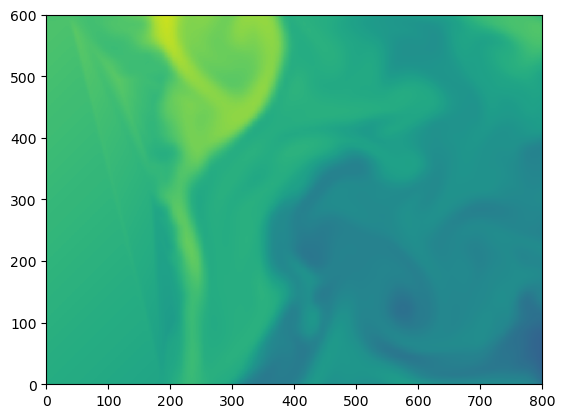

In [22]:
plt.pcolormesh(temp[-1,:,:],vmin=19,vmax=28)

In [23]:
print('making ini file for grid file: ' + grd_file)

# call function that generates the out file
grid_file=grd_file
output_file=out_file
tempbounds=(tempLow,tempUp)
saltbounds=(saltLow,saltUp)


# Read BRAN data and grid
print('Subsetting BRAN data')
theta_ds = theta_full.assign_coords({'xt_ocean': (theta_full['xt_ocean'] + 360) % 360}).sortby('xt_ocean') # re-arrange the x-coordinate
# theta_raw = np.transpose(theta_ds.THETA.values[0,:,0:nbdry_ecco,:])
theta_raw = theta_ds.temp.sel(yt_ocean=slice(*grd_lat_ax),xt_ocean=slice(*grd_lon_ax)).transpose().isel(Time=0)
lon_bran_raw = theta_raw.xt_ocean.values
lat_bran = theta_raw.yt_ocean.values
depth_bran_raw = theta_raw.st_ocean.values

salt_ds = salt_full.assign_coords({'xt_ocean': (salt_full['xt_ocean'] + 360) % 360}).sortby('xt_ocean') # re-arrange the x-coordinate
# salt_raw = np.transpose(salt_ds.SALT.values[0,:,0:nbdry_ecco,:])
salt_raw = salt_ds.salt.sel(yt_ocean=slice(*grd_lat_ax),xt_ocean=slice(*grd_lon_ax)).transpose().isel(Time=0)
# The ECCO2 longitude axis doesn't wrap around; there is a gap between
# almost-180W and almost-180E, and the ROMS grid has points in this gap.
# So copy the last longitude value (mod 360) to the beginning, and the
# first longitude value (mod 360) to the end.
# lon_ecco = np.zeros(np.size(lon_ecco_raw)+2)
# lon_ecco[0] = lon_ecco_raw[-1]-360
# lon_ecco[1:-1] = lon_ecco_raw
# lon_ecco[-1] = lon_ecco_raw[0]+360
lon_bran = lon_bran_raw

# The shallowest ECCO2 depth value is 5 m, but ROMS needs 0 m. So add the
# index depth = 0 m to the beginning. Later we will just copy the 5 m values
# for theta and salt into this index. Similarly, add the index depth = 6000 m
# to the end.
depth_bran = np.zeros(np.size(depth_bran_raw)+2)
depth_bran[0] = 0.0
depth_bran[1:-1] = depth_bran_raw
depth_bran[-1] = 6000.0

# Copy the theta and salt values to the new longitude and depth indices,
# making sure to preserve the mask.
theta = np.ma.array(np.zeros((np.size(lon_bran), np.size(lat_bran), np.size(depth_bran))))
theta[:,:,1:-1] = np.ma.copy(theta_raw) # modification to not overwrite the first/last lon values (so change 1:-1 to :)
# theta[0,:,1:-1] = np.ma.copy(theta_raw[-1,:,:])
# theta[-1,:,1:-1] = np.ma.copy(theta_raw[0,:,:])
theta[:,:,0] = np.ma.copy(theta[:,:,1])
theta[:,:,-1] = np.ma.copy(theta[:,:,-2])
salt = np.ma.array(np.zeros((np.size(lon_bran), np.size(lat_bran), np.size(depth_bran))))
salt[:,:,1:-1] = np.ma.copy(salt_raw)  # modification to not overwrite the first/last lon values (so change 1:-1 to :)
# salt[0,:,1:-1] = np.ma.copy(salt_raw[-1,:,:])
# salt[-1,:,1:-1] = np.ma.copy(salt_raw[0,:,:])
salt[:,:,0] = np.ma.copy(salt[:,:,1])
salt[:,:,-1] = np.ma.copy(salt[:,:,-2])

    
# if ~convertFromTEOS:
#     print('doing a DIRTY conversion from CT to PT by -273.15')
#     theta=theta-273.15

# Read ROMS grid
print('Reading ROMS grid')
grid_fid = Dataset(grid_file, 'r')
lon_roms = grid_fid.variables['lon_rho'][:,:]
#ecco goes from 0 to 360 roms from -180 to 180
for i in range(len(lon_roms)):
    for j in range(len(lon_roms[i])):
        if lon_roms[i,j] < 0:
            lon_roms[i,j] = lon_roms[i,j] + 360
lat_roms = grid_fid.variables['lat_rho'][:,:]
h = grid_fid.variables['h'][:,:]
# zice = grid_fid.variables['zice'][:,:]
mask_rho = grid_fid.variables['mask_rho'][:,:]
#mask_zice = grid_fid.variables['mask_zice'][:,:]
grid_fid.close()
# mask_zice = np.where(zice < 0.0,1,0)*mask_rho
num_lon = np.size(lon_roms, 1)
num_lat = np.size(lon_roms, 0)
# Mask h and zice with zeros
h = h*mask_rho
# zice = zice*mask_zice

# Get a 3D array of ROMS z-coordinates, as well as 1D arrays of s-coordinates
# and stretching curves
z_roms_3d, sc_r, Cs_r = calc_z_old(h, np.full_like(h,0.0), theta_s, theta_b, hc, N)
# Copy the latitude and longitude values into 3D arrays of the same shape
lon_roms_3d = np.tile(lon_roms, (N,1,1))
lat_roms_3d = np.tile(lat_roms, (N,1,1))

# Regridding happens here...
print('Interpolating temperature')
temp = interp_bran2roms(theta, lon_bran, lat_bran, depth_bran, lon_roms_3d, lat_roms_3d, z_roms_3d, mask_rho, np.full_like(h,0))
print('Interpolating salinity')
salt = interp_bran2roms(salt, lon_bran, lat_bran, depth_bran, lon_roms_3d, lat_roms_3d, z_roms_3d, mask_rho, np.full_like(h,0))

# setting bounds for temperture and salinity
# tempLow,tempUp=tempbounds
# saltLow,saltUp=saltbounds
# temp[temp < tempLow] = tempLow
# temp[temp > tempUp] = tempUp
# salt[salt < saltLow] = saltLow
# salt[salt > saltUp] = saltUp 

# apply some smoothing of each layer 2d field to remove any sharp gradients in temp/salinity.


def smooth_initialfield(N,field):
    import scipy as sp
    import scipy.ndimage
    
    field_new = np.empty(field.shape)

    for k in range(N):
        print('processing depth level: ',k)
        data = field[k]
        
        
        sigma_y = 2.0
        sigma_x = 2.0
        sigma = [sigma_y, sigma_x]

        data_smoothed = sp.ndimage.gaussian_filter(data, sigma, mode='nearest')
        
        
        field_new[k] = data_smoothed
    return field_new
        
temp_backup = temp.copy()
temp = smooth_initialfield(N,temp)
salt_backup = salt.copy()
salt = smooth_initialfield(N,salt)



# Set initial velocities and sea surface height to zero
u = np.zeros((N, num_lat, num_lon-1))
v = np.zeros((N, num_lat-1, num_lon))
ubar = np.zeros((num_lat, num_lon-1))
vbar = np.zeros((num_lat-1, num_lon))
zeta = np.zeros((num_lat, num_lon))

print('Writing to NetCDF file')
out_fid = Dataset(output_file, 'w')
# Define dimensions
out_fid.createDimension('xi_u', num_lon-1)
out_fid.createDimension('xi_v', num_lon)
out_fid.createDimension('xi_rho', num_lon)
out_fid.createDimension('eta_u', num_lat)
out_fid.createDimension('eta_v', num_lat-1)
out_fid.createDimension('eta_rho', num_lat)
out_fid.createDimension('s_rho', N)
out_fid.createDimension('ocean_time', None)
out_fid.createDimension('one', 1)
# Define variables and assign values
out_fid.createVariable('tstart', 'f8', ('one'))
out_fid.variables['tstart'].long_name = 'start processing day'
out_fid.variables['tstart'].units = 'day'
out_fid.variables['tstart'][:] = 0.0
out_fid.createVariable('tend', 'f8', ('one'))
out_fid.variables['tend'].long_name = 'end processing day'
out_fid.variables['tend'].units = 'day'
out_fid.variables['tend'][:] = 0.0
out_fid.createVariable('theta_s', 'f8', ('one'))
out_fid.variables['theta_s'].long_name = 'S-coordinate surface control parameter'
out_fid.variables['theta_s'][:] = theta_s
out_fid.createVariable('theta_b', 'f8', ('one'))
out_fid.variables['theta_b'].long_name = 'S-coordinate bottom control parameter'
out_fid.variables['theta_b'].units = 'nondimensional'
out_fid.variables['theta_b'][:] = theta_b
out_fid.createVariable('Tcline', 'f8', ('one'))
out_fid.variables['Tcline'].long_name = 'S-coordinate surface/bottom layer width'
out_fid.variables['Tcline'].units = 'meter'
out_fid.variables['Tcline'][:] = Tcline
out_fid.createVariable('hc', 'f8', ('one'))
out_fid.variables['hc'].long_name = 'S-coordinate parameter, critical depth'
out_fid.variables['hc'].units = 'meter'
out_fid.variables['hc'][:] = hc
out_fid.createVariable('Cs_r', 'f8', ('s_rho'))
out_fid.variables['Cs_r'].long_name = 'S-coordinate stretching curves at RHO-points'
out_fid.variables['Cs_r'].units = 'nondimensional'
out_fid.variables['Cs_r'].valid_min = -1.0
out_fid.variables['Cs_r'].valid_max = 0.0
out_fid.variables['Cs_r'][:] = Cs_r
out_fid.createVariable('ocean_time', 'f8', ('ocean_time'))
out_fid.variables['ocean_time'].long_name = 'time since initialization'
out_fid.variables['ocean_time'].units = 'seconds'
out_fid.variables['ocean_time'][0] = 0.0
out_fid.createVariable('u', 'f8', ('ocean_time', 's_rho', 'eta_u', 'xi_u'))
out_fid.variables['u'].long_name = 'u-momentum component'
out_fid.variables['u'].units = 'meter second-1'
out_fid.variables['u'][0,:,:,:] = u
out_fid.createVariable('v', 'f8', ('ocean_time', 's_rho', 'eta_v', 'xi_v'))
out_fid.variables['v'].long_name = 'v-momentum component'
out_fid.variables['v'].units = 'meter second-1'
out_fid.variables['v'][0,:,:,:] = v
out_fid.createVariable('ubar', 'f8', ('ocean_time', 'eta_u', 'xi_u'))
out_fid.variables['ubar'].long_name = 'vertically integrated u-momentum component'
out_fid.variables['ubar'].units = 'meter second-1'
out_fid.variables['ubar'][0,:,:] = ubar
out_fid.createVariable('vbar', 'f8', ('ocean_time', 'eta_v', 'xi_v'))
out_fid.variables['vbar'].long_name = 'vertically integrated v-momentum component'
out_fid.variables['vbar'].units = 'meter second-1'
out_fid.variables['vbar'][0,:,:] = vbar
out_fid.createVariable('zeta', 'f8', ('ocean_time', 'eta_rho', 'xi_rho'))
out_fid.variables['zeta'].long_name = 'free-surface'
out_fid.variables['zeta'].units = 'meter'
out_fid.variables['zeta'][0,:,:] = zeta
out_fid.createVariable('temp', 'f8', ('ocean_time', 's_rho', 'eta_rho', 'xi_rho'))
out_fid.variables['temp'].long_name = 'potential temperature'
out_fid.variables['temp'].units = 'Celsius'
out_fid.variables['temp'][0,:,:,:] = temp
out_fid.createVariable('salt', 'f8', ('ocean_time', 's_rho', 'eta_rho', 'xi_rho'))
out_fid.variables['salt'].long_name = 'salinity'
out_fid.variables['salt'].units = 'PSU'
out_fid.variables['salt'][0,:,:,:] = salt
out_fid.createVariable('sc_r', 'f8', ('s_rho'))
out_fid.variables['sc_r'].long_name = 'S-coordinate at rho-points'
out_fid.variables['sc_r'].units = 'nondimensional'
out_fid.variables['sc_r'].valid_min = -1.0
out_fid.variables['sc_r'].valid_max = 0.0
out_fid.variables['sc_r'][:] = sc_r
out_fid.close()

print('Finished')

making ini file for grid file: /home/woden/Documents/se-qld-setup/data/proc/seqld_1km_v1.5_grd.nc
Subsetting BRAN data
Reading ROMS grid
Interpolating temperature
...vertical level  1  of  31
...vertical level  2  of  31
...vertical level  3  of  31
...vertical level  4  of  31
...vertical level  5  of  31
...vertical level  6  of  31
...vertical level  7  of  31
...vertical level  8  of  31
...vertical level  9  of  31
...vertical level  10  of  31
...vertical level  11  of  31
...vertical level  12  of  31
...vertical level  13  of  31
...vertical level  14  of  31
...vertical level  15  of  31
...vertical level  16  of  31
...vertical level  17  of  31
...vertical level  18  of  31
...vertical level  19  of  31
...vertical level  20  of  31
...vertical level  21  of  31
...vertical level  22  of  31
...vertical level  23  of  31
...vertical level  24  of  31
...vertical level  25  of  31
...vertical level  26  of  31
...vertical level  27  of  31
...vertical level  28  of  31
...ver

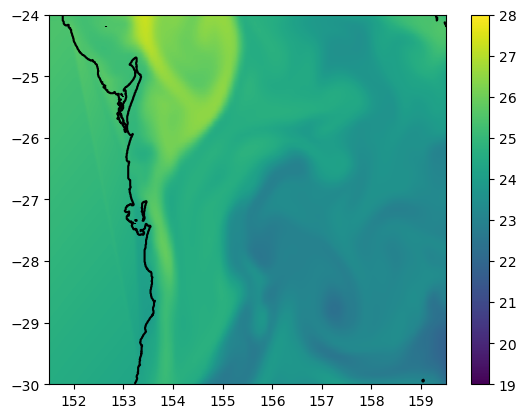

In [24]:
## test masking all sub-ice cells, and re-introduce constant ICs here
out = xr.open_dataset(out_file)
out

grd = xr.open_dataset(grd_file)
grd

plt.pcolormesh(grd.lon_rho,grd.lat_rho,out.temp.isel(ocean_time=0,s_rho=-1).squeeze(),vmin=19,vmax=28)
plt.colorbar()
plt.contour(grd.lon_rho,grd.lat_rho,grd.mask_rho,levels=np.array((-1,0)),colors='k',zorder=10)
# plt.axis((*grd_lon_ax,*grd_lat_ax))
plot_axes = (*plt.gca().get_xlim(),*plt.gca().get_ylim())
plt.show()


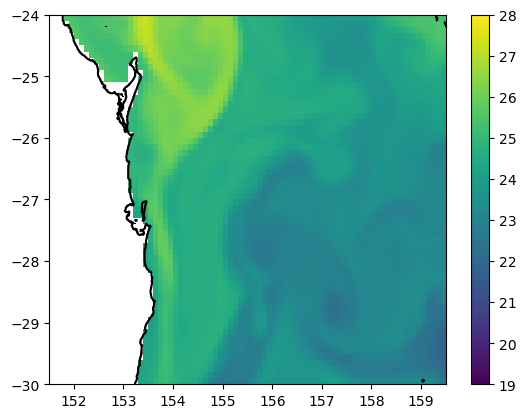

In [25]:
XX,YY = np.meshgrid(lon_bran,lat_bran)

plt.pcolormesh(XX,YY,theta[:,:,0].T,shading='nearest',vmin=19,vmax=28)
plt.colorbar()
plt.axis(plot_axes)
plt.contour(grd.lon_rho,grd.lat_rho,grd.mask_rho,levels=np.array((-1,0)),colors='k',zorder=10)
